In [2]:
# working with, mainly resizing, images
import cv2
# dealing with arrays
import numpy as np
# dealing with directories
import os
# mixing up or currently ordered data that might lead our network astray in training
from random import shuffle
# nice pretty percentage bar for tasks
from tqdm import tqdm

In [3]:
#loading the dataset and sinec the dataset is big we are using directory
TRAIN_DIR = 'C:/Users/18579/Desktop/dogs-vs-cats-redux-kernels-edition/train/train'
TEST_DIR = 'C:/Users/18579/Desktop/dogs-vs-cats-redux-kernels-edition/test/test'
IMG_SIZE = 50
LR = 1e-3
MODEL_NAME = 'Dog-vs-Cats-Classifier'

In [4]:
#Images are labeled like "cat.1" or "dog.3" and so on, so we can just split out the dog/cat, and then convert to an array 
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

In [5]:
#Build another function to fully process the training images and their labels into arrays
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [6]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [7]:
# run the training:

train_data = create_train_data()

100%|██████████| 24957/24957 [01:16<00:00, 324.23it/s]


In [9]:
test_data = process_test_data()

100%|██████████| 12428/12428 [00:37<00:00, 335.68it/s]


In [10]:
pip install tflearn

Note: you may need to restart the kernel to use updated packages.


In [13]:
#Lets define our neural network but first need to upload libraries
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

In [15]:
#Splitting the test and train
train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [16]:
#Building the model
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [17]:
#Fitting the model
model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 3829  | total loss: 0.30553 | time: 29.770s
| Adam | epoch: 010 | loss: 0.30553 - acc: 0.8759 -- iter: 24448/24457
Training Step: 3830  | total loss: 0.30345 | time: 30.899s
| Adam | epoch: 010 | loss: 0.30345 - acc: 0.8774 | val_loss: 0.51894 - val_acc: 0.8040 -- iter: 24457/24457
--


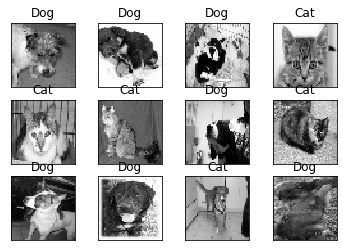

In [19]:
import matplotlib.pyplot as plt
#Checking the predictions


fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()